# 离散余弦变换(DCT，Discrete Cosine Transform)
- https://www.cnblogs.com/wyuzl/p/7880124.html
- 相比DFT而言，只保留了实数部分，并且能量大都集中在左上角部分
- 根据DCT的特性，提出Z-Scan，以左上角为起点进行扫描，因此会容易出现大量的连续0，进而实现压缩

## 2D正变换-DCT
### 
$$
    F(u, v) = c(u)c(v) \sum_{x=0}^{X_{size}-1}\sum_{y=0}^{Y_{size}-1}f(x, y)\cos[\frac{(x+0.5)\pi}{X_{size}}u]\cos[\frac{(y+0.5)\pi}{Y_{size}}v] \\
    c(u) = \left\{
\begin{aligned}
\sqrt{\frac{1}{U_{size}}} & , & u=0 \\
\sqrt{\frac{2}{U_{size}}} & , & u\neq0
\end{aligned}
\right.  \\
    c(v) = \left\{
\begin{aligned}
\sqrt{\frac{1}{V_{size}}} & , & v=0 \\
\sqrt{\frac{2}{V_{size}}} & , & v\neq0
\end{aligned}
\right.
$$

## 2D逆变换-IDCT
### 
$$
    f(x, y) = \sum_{u=0}^{U_{size}-1}\sum_{v=0}^{V_{size}-1}c(u)c(v)F(u, v)\cos[\frac{(x+0.5)\pi}{X_{size}}u]\cos[\frac{(y+0.5)\pi}{Y_{size}}v] \\
    c(u) = \left\{
\begin{aligned}
\sqrt{\frac{1}{U_{size}}} & , & u=0 \\
\sqrt{\frac{2}{U_{size}}} & , & u\neq0
\end{aligned}
\right.  \\
    c(v) = \left\{
\begin{aligned}
\sqrt{\frac{1}{V_{size}}} & , & v=0 \\
\sqrt{\frac{2}{V_{size}}} & , & v\neq0
\end{aligned}
\right.
$$

- 由于DCT的对称性，可以用矩阵方式表达更为简单
- 2D的DCT处理时，$U_{size} == X_{size}, V_{size} == Y_{size}$，对应的是图像的宽高，网上全部用N表示容易矛盾冲突
- DCT由DFT去掉虚部推导而来

In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

In [2]:
def dct2d(image, xnfreq, ynfreq):
    yndata  = image.shape[0]
    xndata  = image.shape[1]

    output = np.zeros((ynfreq, xnfreq))
    for xifreq in range(xnfreq):
        for yifreq in range(ynfreq):
            cx = np.sqrt(1 / xnfreq) if xifreq == 0 else np.sqrt(2 / xnfreq)
            cy = np.sqrt(1 / ynfreq) if yifreq == 0 else np.sqrt(2 / ynfreq)
            for xidata in range(xndata):
                for yidata in range(yndata):
                    output[yifreq, xifreq] += image[yidata, xidata] * np.cos((xidata + 0.5) * np.pi / xndata * xifreq) * np.cos((yidata + 0.5) * np.pi / yndata * yifreq)
            
            output[yifreq, xifreq] *= cx * cy
    return output

def idct2d(dct_image, xndata, yndata):
    ynfreq  = dct_image.shape[0]
    xnfreq  = dct_image.shape[1]
    
    image = np.zeros((yndata, xndata))
    for xidata in range(xndata):
        for yidata in range(yndata):
            for xifreq in range(xnfreq):
                for yifreq in range(ynfreq):
                    cx = np.sqrt(1 / xnfreq) if xifreq == 0 else np.sqrt(2 / xnfreq)
                    cy = np.sqrt(1 / ynfreq) if yifreq == 0 else np.sqrt(2 / ynfreq)
                    image[yidata, xidata] += cx * cy * dct_image[yifreq, xifreq] * np.cos((xidata + 0.5) * np.pi / xnfreq * xifreq) * np.cos((yidata + 0.5) * np.pi / ynfreq * yifreq)
    return image

In [3]:
image = cv2.resize(cv2.imread("bck.png", 0), (28, 28)) / 255.0

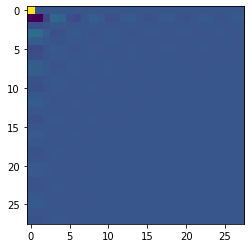

In [4]:
width = image.shape[1]
height = image.shape[0]
dct_image = dct2d(image, width, height)
plt.imshow(dct_image)

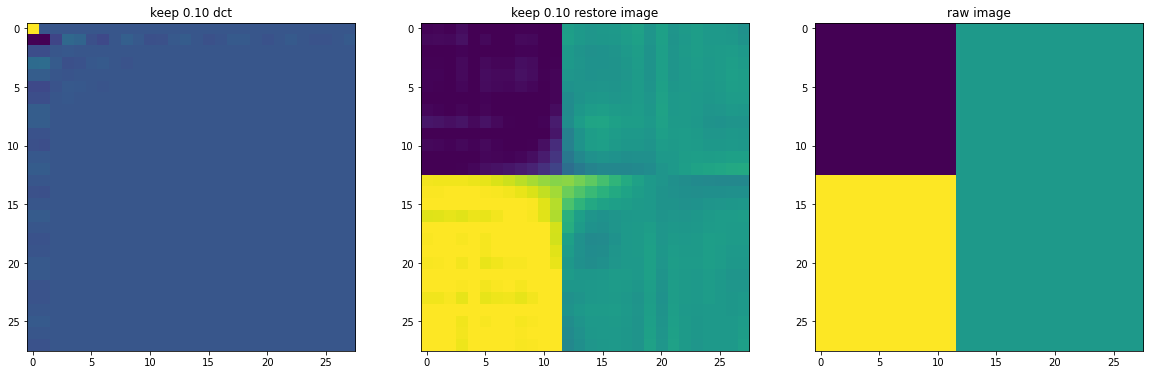

In [15]:
dct_vector = dct_image.reshape(-1)
dct_index = np.arange(len(dct_vector))
dct_union = list(zip(dct_vector, np.abs(dct_vector), dct_index))
dct_union_sort = list(sorted(dct_union, key=lambda x: x[1], reverse=True))

keep_prob = 0.1
keep_dims = int(keep_prob * len(dct_union_sort))
keep_vector, _, keep_index = zip(*dct_union_sort[:keep_dims])
dct_new_vector = np.zeros(dct_vector.shape)
dct_new_vector[np.array(keep_index)] = keep_vector
keep_dct = dct_new_vector.reshape(28, 28)

plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.title(f"keep {keep_prob:.2f} dct")
plt.imshow(keep_dct)

restore_image = idct2d(keep_dct, width, height)
plt.subplot(1, 3, 2)
plt.title(f"keep {keep_prob:.2f} restore image")
plt.imshow(restore_image, vmin=0, vmax=1)

plt.subplot(1, 3, 3)
plt.title(f"raw image")
plt.imshow(image, vmin=0, vmax=1)

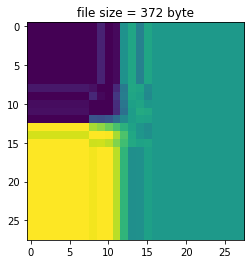

In [6]:
cv2.imwrite("temp.jpg", cv2.imread("bck.png", 0), [cv2.IMWRITE_JPEG_QUALITY, 10])
temp_jpg = cv2.imread("temp.jpg", 0)

file_size = os.path.getsize("temp.jpg")
plt.title(f"file size = {file_size} byte")
plt.imshow(temp_jpg, vmin=0, vmax=255)

## Z-Scan

![](zscan.png)